In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import sklearn
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures#数据预处理，标准化
from sklearn.pipeline import Pipeline
from sklearn.linear_model.coordinate_descent import ConvergenceWarning

In [2]:
## 设置字符集，防止中文乱码
mpl.rcParams['font.sans-serif']=[u'simHei']
mpl.rcParams['axes.unicode_minus']=False
## 拦截异常
warnings.filterwarnings(action = 'ignore', category=ConvergenceWarning)

In [16]:
## 创建模拟数据
np.random.seed(100)
np.set_printoptions(linewidth=1000, suppress=True)#显示方式设置，每行的字符数用于插入换行符，是否使用科学计数法
N = 10
x = np.linspace(0, 6, N) + np.random.randn(N)
y = 1.8*x**3 + x**2 - 14*x - 7 + np.random.randn(N)
## 将其设置为矩阵
x.shape = -1, 1
y.shape = -1, 1

In [28]:
## RidgeCV和Ridge的区别是：前者可以进行交叉验证
models = [
    Pipeline([
            ('Poly', PolynomialFeatures(include_bias=True)),
            ('Linear', LinearRegression(fit_intercept=False))
        ]),
    Pipeline([
            ('Poly', PolynomialFeatures(include_bias=True)),
            # alpha给定的是Ridge算法中，L2正则项的权重值，也就是ppt中的兰姆达
            # alphas是给定CV交叉验证过程中，Ridge算法的alpha参数值的取值的范围
            ('Linear', RidgeCV(alphas=np.logspace(-3,2,50), fit_intercept=False))
        ]),
    Pipeline([
            ('Poly', PolynomialFeatures(include_bias=True)),
            ('Linear', LassoCV(alphas=np.logspace(0,1,10), fit_intercept=False))
        ]),
    Pipeline([
            ('Poly', PolynomialFeatures(include_bias=True)),
            # la_ratio：给定EN算法中L1正则项在整个惩罚项中的比例，这里给定的是一个列表；
            # 表示的是在CV交叉验证的过程中，EN算法L1正则项的权重比例的可选值的范围
            ('Linear', ElasticNetCV(alphas=np.logspace(0,1,10), l1_ratio=[.1, .5, .7, .9, .95, 1], fit_intercept=False))
        ])
]

1阶，系数为： [-44.14102611  40.05964256]
5阶，系数为： [ -5.60899679 -14.80109301   0.75014858   2.11170671  -0.07724668   0.00566633]
9阶，系数为： [-2465.58381316  6108.63817712 -5111.99333504   974.74974891  1078.89649478  -829.50277842   266.13230658   -45.71741587     4.1158274     -0.15281063]


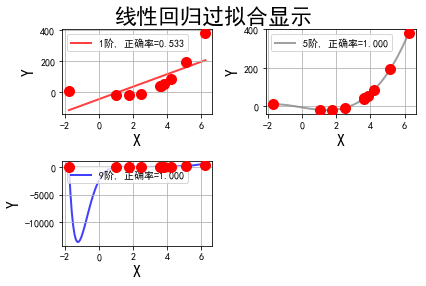

In [29]:
## 线性模型过拟合图形识别
plt.figure(facecolor='w')
degree = np.arange(1,N,4) # 阶
dm = degree.size
colors = [] # 颜色
for c in np.linspace(16711680, 255, dm):
    colors.append('#%06x' % int(c))

model = models[0]
for i,d in enumerate(degree):
    plt.subplot(int(np.ceil(dm/2.0)),2,i+1)
    plt.plot(x, y, 'ro', ms=10, zorder=N)

    # 设置阶数
    model.set_params(Poly__degree=d)
    # 模型训练
    model.fit(x, y.ravel())
    
    lin = model.get_params()['Linear']
    output = u'%d阶，系数为：' % (d)
    print (output, lin.coef_.ravel())
    
    x_hat = np.linspace(x.min(), x.max(), num=100) ## 产生模拟数据
    x_hat.shape = -1,1
    y_hat = model.predict(x_hat)
    s = model.score(x, y)
    
    z = N - 1 if (d == 5) else 0
    label = u'%d阶, 正确率=%.3f' % (d,s)
    plt.plot(x_hat, y_hat, color=colors[i], lw=2, alpha=0.75, label=label, zorder=z)
    
    plt.legend(loc = 'upper left')
    plt.grid(True)
    plt.xlabel('X', fontsize=16)
    plt.ylabel('Y', fontsize=16)

plt.tight_layout(1, rect=(0,0,1,0.95))
plt.suptitle(u'线性回归过拟合显示', fontsize=22)
plt.show()

线性回归:1阶，系数为： [-44.14102611  40.05964256]
线性回归:3阶，系数为： [ -6.80525963 -13.743068     0.93453895   1.79844791]
线性回归:5阶，系数为： [ -5.60899679 -14.80109301   0.75014858   2.11170671  -0.07724668   0.00566633]
线性回归:7阶，系数为： [-41.70721172  52.38570529 -29.56451338  -7.66322829  12.07162703  -3.86969096   0.53286096  -0.02725536]
线性回归:9阶，系数为： [-2465.58381316  6108.63817712 -5111.99333504   974.74974891  1078.89649478  -829.50277842   266.13230658   -45.71741587     4.1158274     -0.15281063]
Ridge回归:1阶，alpha=9.540955, 系数为： [ -6.71593385  29.79090057]
Ridge回归:3阶，alpha=0.005179, 系数为： [ -6.7819845  -13.73679293   0.92827639   1.79920954]
Ridge回归:5阶，alpha=39.069399, 系数为： [-0.82920155 -1.07244754 -1.41803017 -0.93057536  0.88319116 -0.07073168]
Ridge回归:7阶，alpha=9.540955, 系数为： [-1.62586368 -2.18512108 -1.82690987 -2.27495708  0.98685071  0.30551091 -0.10988434  0.00846908]
Ridge回归:9阶，alpha=0.021210, 系数为： [-10.50566712  -6.12564342  -1.96421973   0.80200162   0.59148104  -0.23358238   0.20296996  -0.0810

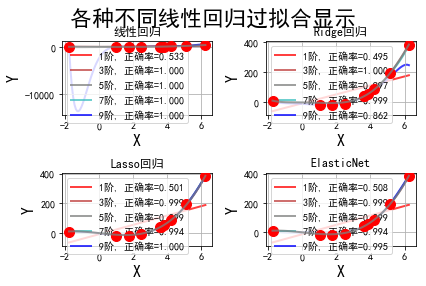

In [30]:
## 线性回归、Lasso回归、Ridge回归、ElasticNet比较
plt.figure(facecolor='w')
degree = np.arange(1,N, 2) # 阶， 多项式扩展允许给定的阶数
dm = degree.size
colors = [] # 颜色
for c in np.linspace(16711680, 255, dm):
    colors.append('#%06x' % int(c))
titles = [u'线性回归', u'Ridge回归', u'Lasso回归', u'ElasticNet']

for t in range(4):
    model = models[t]#选择了模型--具体的pipeline(线性、Lasso、Ridge、EN)
    plt.subplot(2,2,t+1) # 选择具体的子图
    plt.plot(x, y, 'ro', ms=10, zorder=N - 1) # 在子图中画原始数据点； zorder：图像显示在第几层

    # 遍历不同的多项式的阶，看不同阶的情况下，模型的效果
    for i,d in enumerate(degree):
        # 设置阶数(多项式)
        model.set_params(Poly__degree=d)
        # 模型训练
        model.fit(x, y.ravel())

        # 获取得到具体的算法模型
        # model.get_params()方法返回的其实是一个dict对象，后面的Linear其实是dict对应的key
        # 也是我们在定义Pipeline的时候给定的一个名称值
        lin = model.get_params()['Linear']
        # 打印数据
        output = u'%s:%d阶，系数为：' % (titles[t],d)
        # 判断lin对象中是否有对应的属性
        if hasattr(lin, 'alpha_'): # 判断lin这个模型中是否有alpha_这个属性
            idx = output.find(u'系数')
            output = output[:idx] + (u'alpha=%.6f, ' % lin.alpha_) + output[idx:]
        if hasattr(lin, 'l1_ratio_'): # 判断lin这个模型中是否有l1_ratio_这个属性
            idx = output.find(u'系数')
            output = output[:idx] + (u'l1_ratio=%.6f, ' % lin.l1_ratio_) + output[idx:]
        # line.coef_：获取线性模型的参数列表，也就是我们ppt中的theta值，ravel()将结果转换为1维数据
        print (output, lin.coef_.ravel())

        # 产生模拟数据
        x_hat = np.linspace(x.min(), x.max(), num=100) ## 产生模拟数据
        x_hat.shape = -1,1
        # 数据预测
        y_hat = model.predict(x_hat)
        # 计算准确率
        s = model.score(x, y)

        # 当d等于5的时候，设置为N-1层，其它设置0层；将d=5的这条线凸显出来
        z = N + 1 if (d == 5) else 0
        label = u'%d阶, 正确率=%.3f' % (d,s)
        plt.plot(x_hat, y_hat, color=colors[i], lw=2, alpha=0.75, label=label, zorder=z)
    
    plt.legend(loc = 'upper left')
    plt.grid(True)
    plt.title(titles[t])
    plt.xlabel('X', fontsize=16)
    plt.ylabel('Y', fontsize=16)
plt.tight_layout(1, rect=(0,0,1,0.95))
plt.suptitle(u'各种不同线性回归过拟合显示', fontsize=22)
plt.show()